In [2]:
import sys
sys.path.append('./Alignment')
sys.path.append('./ACLSSL')

# Sound Source Localization is All about Cross-Modal Alignment (ICCV 2023)
### Arda Senocak*, Hyeonggon Ryu*, Junsik Kim*, Tae-Hyun Oh, Hanspeter Pfister, Joon Son Chung

## Section 1 - Initialize Alignment Model

* Set up the environment and initializes the for Audio-Visual Alignment model.

In [3]:
# Import necessary libraries
import os
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Audio
from functools import reduce
import cv2
import numpy as np
from pycocotools import mask as mask_utils
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.optim import *
import torchvision
from torchvision.transforms import *
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
import json
import time

from Alignment.model import AlignmentNet
from Alignment.datasets.dataloader_vggss import GetAudioVideoDataset

from opt_name import get_name
from utils import *

import xml.etree.ElementTree as ET
from sklearn.metrics import auc
import importlib



import easydict
args = easydict.EasyDict({
        "data_path" : '/mnt/lynx1/datasets/',  # Path to the dataset
        "image_size": 224,  # Input image size for the model
        "batch_size" : 16,  # Batch size for training
        "n_threads" : 10,  # Number of threads for data loading
        "epsilon" : 0.65,  # Epsilon value for a specific process
        "epsilon2" : 0.4,  # Another epsilon value for different process
        'tri_map' : True,  # Use trimap in the process
        'Neg' : True,  # Flag to use negative samples
        'random_threshold' : 1,  # Threshold for random sampling
        'soft_ep' : 1,  # Soft epsilon for process smoothing
        'testset' :'vggss',  # Dataset name for testing
        'aug' : True,  # Use data augmentation
        'hp' : True,  # Use hard-positive(similar)
        'feature' : True,  # Feature Alignment
        'intra' : True,  # Use intra-class loss
        'aug_intra' : True  # Augment intra-class loss
})
device = torch.device("cpu")
Alignment_model = AlignmentNet(args)

## Section 2 - Initialize Train Loader
* Initialize the dataset loader, and run a sanity check.
* The loader handles audio and image data loading, augmentation, and transformation for training an alignment model.
* Please verify whether the loaded semantically similar sample, and the augmented sample looks proper.

In [4]:
import soundfile as sf
from scipy import signal

# Load the list of sample files (small part of VGGSound) from a JSON file
with open('samples.json') as fi:
    samples = json.load(fi)

class trainloader():
    def __init__(self):
        self.files = samples  # List of sample files
        self.audio_path = './vggsound_40/audio/'  # Path to audio files
        self.visual_path = './vggsound_40/image/'  # Path to image files
        self.imgSize = 224  # Size of the image input
        self._init_transform()  # Initialize image transformations
        self._init_atransform()  # Initialize audio transformations

    def _init_transform(self):
        # Define normalization parameters
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        # Image transformation pipeline for standard images
        self.img_transform = transforms.Compose([
            transforms.Resize(int(self.imgSize * 1.1), Image.BICUBIC),
            transforms.RandomCrop(self.imgSize),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(self.imgSize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        # Image transformation pipeline with augmentations
        self.aug_img_transform = transforms.Compose([
            transforms.Resize(int(self.imgSize * 1.1), Image.BICUBIC),
            transforms.RandomCrop(self.imgSize),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomAffine(degrees=0, translate=((0.2, 0.2))),
            transforms.CenterCrop(self.imgSize),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        # Original augmented image transformation (for visualization)
        self.ori_aug_img_transform = transforms.Compose([
            transforms.Resize(int(self.imgSize * 1.1), Image.BICUBIC),
            transforms.RandomCrop(self.imgSize),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomAffine(degrees=0, translate=((0.2, 0.2))),
            transforms.CenterCrop(self.imgSize),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor()
        ])

        # Original image transformation (for visualization)
        self.ori_img_transform = transforms.Compose([
            transforms.Resize(int(self.imgSize * 1.1), Image.BICUBIC),
            transforms.RandomCrop(self.imgSize),
            transforms.ToTensor()
        ])

        # Additional augmentations
        self.aug_jitter = transforms.Compose([
            transforms.ColorJitter(brightness=(0, 0.4), contrast=(0, 0.4), saturation=(0, 0.4), hue=(0, 0.1))
        ])

        self.aug_Gaussian = transforms.Compose([
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
        ])

    def _init_atransform(self):
        # Audio transformation pipeline
        self.aid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.0], std=[12.0])
        ])

    def _load_frame(self, path, aug=False):
        # Load an image frame from the specified path
        img = Image.open(path).convert('RGB')
        
        # Apply random augmentations if specified
        if aug:
            img = transforms.functional.rotate(img, angle=np.random.randint(4) * 90)
            jitter_p = np.random.randint(5)
            if jitter_p != 0:
                img = self.aug_jitter(img)
            blurr_p = np.random.randint(2)
            if blurr_p != 0:
                img = self.aug_Gaussian(img)

        return img

    def _load_audio(self, file, aug=False, offset=0):
        # Load an audio file and apply transformations
        samples, samplerate = sf.read(file)

        # Repeat the audio if it is too short
        if samples.shape[0] < samplerate * 10:
            n = int(samplerate * 10 / samples.shape[0]) + 1
            samples = np.tile(samples, n)
        resamples = samples[:samplerate*10]

        # Apply random offset to the audio
        offset = np.random.randint(56000 * 2) - 56000
        resamples = resamples[int(16000 * 3.5) + offset : int(16000 * 6.5) + offset]

        # Clip the audio samples to be between -1 and 1
        resamples[resamples > 1.] = 1.
        resamples[resamples < -1.] = -1.

        # Generate spectrogram and transform it
        frequencies, times, spectrogram = signal.spectrogram(resamples, samplerate, nperseg=512, noverlap=353)
        spectrogram = np.log(spectrogram + 1e-7)
        spectrogram = self.aid_transform(spectrogram)

        return torch.tensor(spectrogram).float(), resamples

    def getitem(self, idx):
        # Get data items for a given index 0: Original, 1: V_Similar, 2: A_Similar
        file = self.files[idx][0]

        # Load image and audio for the given index
        frame = self.img_transform(self._load_frame(os.path.join(self.visual_path, file + '.jpg'))).float()
        frame_ori = self.ori_img_transform(self._load_frame(os.path.join(self.visual_path, file + '.jpg')))

        # Load audio spectrogram
        spectrogram, resamples = self._load_audio(os.path.join(self.audio_path, file + '.wav'))

        # Load Semantically Similar image and audio for verification
        v_hp_file = self.files[idx][1]
        a_hp_file = self.files[idx][2]

        # Image
        v_hp_frame = self.img_transform(self._load_frame(os.path.join(self.visual_path, v_hp_file + '.jpg'))).float()
        v_hp_frame_ori = self.ori_img_transform(self._load_frame(os.path.join(self.visual_path, v_hp_file + '.jpg')))

        # Audio
        a_hp_spectrogram, a_hp_resamples = self._load_audio(os.path.join(self.audio_path, a_hp_file + '.wav'))

        # Augmentations
        aug_frame = self.aug_img_transform(self._load_frame(os.path.join(self.visual_path, file + '.jpg'))).float()
        aug_frame_ori = self.ori_aug_img_transform(self._load_frame(os.path.join(self.visual_path, file + '.jpg')))
        aug_spectrogram, aug_resamples = self._load_audio(os.path.join(self.audio_path, file + '.wav'))

        # Add an additional dimension for batch processing
        frame = frame.unsqueeze(0)
        spectrogram = spectrogram.unsqueeze(0)
        v_hp_frame = v_hp_frame.unsqueeze(0)
        a_hp_spectrogram = a_hp_spectrogram.unsqueeze(0)
        aug_frame = aug_frame.unsqueeze(0)
        aug_spectrogram = aug_spectrogram.unsqueeze(0)

        # Return all loaded and transformed data
        return frame, v_hp_frame, aug_frame, \
            spectrogram, a_hp_spectrogram, aug_spectrogram, \
            frame_ori, v_hp_frame_ori, aug_frame_ori, \
            resamples, a_hp_resamples, aug_resamples, \
            file, 0  # Box set to 0

    def getitems(self):
        # Load a batch of items (4 in this example)
        frames = []
        v_hp_frames = []
        aug_frames = []
        spectrograms = []
        a_hp_spectrograms = []
        aug_spectrograms = []

        # Iterate over 4 samples and collect data
        for ii in range(4):
            frame, v_hp_frame, aug_frame, \
            spectrogram, a_hp_spectrogram, aug_spectrogram, \
            _, _, _, \
            _, _, _, \
            _, _ = self.getitem(ii)

            frames.append(frame)
            v_hp_frames.append(v_hp_frame)
            aug_frames.append(aug_frame)
            spectrograms.append(spectrogram)
            a_hp_spectrograms.append(a_hp_spectrogram)
            aug_spectrograms.append(aug_spectrogram)

        # Combine individual tensors into batches
        frames = torch.vstack(frames)
        v_hp_frames = torch.vstack(v_hp_frames)
        aug_frames = torch.vstack(aug_frames)
        spectrograms = torch.vstack(spectrograms)
        a_hp_spectrograms = torch.vstack(a_hp_spectrograms)
        aug_spectrograms = torch.vstack(aug_spectrograms)

        return frames, v_hp_frames, aug_frames, spectrograms, a_hp_spectrograms, aug_spectrograms

# Initialize the train loader
train_loader = trainloader()


### Get the data samples for a sanity check

In [31]:
batch = train_loader.getitem(4)
frame,v_hp_frame,aug_frame,\
    spectrogram,a_hp_spectrogram,aug_spectrogram,\
    frame_ori,v_hp_frame_ori,aug_frame_ori,\
    resamples,a_hp_resamples,aug_resamples,\
    file, box = batch

### Display the samples

Text(0.5, 1.0, 'Hand-crafted Aug.')

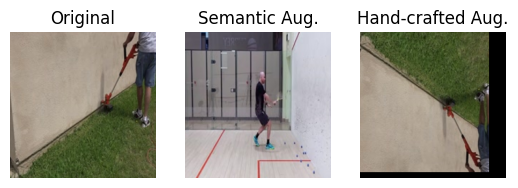

In [32]:
frame_ori = Image.fromarray(((frame_ori.permute(1,2,0)).numpy()*255).astype(np.uint8))
v_hp_frame_ori = Image.fromarray(((v_hp_frame_ori.permute(1,2,0)).numpy()*255).astype(np.uint8))
aug_frame_ori = Image.fromarray(((aug_frame_ori.permute(1,2,0)).numpy()*255).astype(np.uint8))
plt.subplot(1,3,1)
plt.imshow(frame_ori)
plt.axis('off')
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(v_hp_frame_ori)
plt.title('Semantic Aug.')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(aug_frame_ori)
plt.axis('off')
plt.title('Hand-crafted Aug.')

### Original Audio

In [20]:
Audio(resamples,rate=16000)

### Semantically Similar Audio

In [7]:
Audio(a_hp_resamples,rate=16000)

### Augmented Audio

In [8]:
Audio(aug_resamples,rate=16000)

### Get the data samples for training

In [9]:
batch = train_loader.getitems()
frame,v_hp_frame,aug_frame,\
    spectrogram,a_hp_spectrogram,aug_spectrogram = batch

## Section 3 - Training
* Train the model.
* The table shows how the alignment loss is constructed.

In [10]:
'''
Explanation of Logit Structure:
The following matrices represent different logit values obtained from the model. The logits are organized based on the modality (audio or visual) and augmentation status.

loss_{} = NCELoss(Simillarity Matrix_{})

Simillarity Matrix
┌───────┬──────────┬──────────┬──────────┐
│       │  {}_v_0  │  {}_v_1  │  {}_v_2  │ 
├───────┼──────────┼──────────┼──────────┤
│{}_a_0 │ sim(0,0) │ sim(0,1) │ sim(0,2) │  
├───────┼──────────┼──────────┼──────────┤
│{}_a_1 │ sim(1,0) │ sim(1,1) │ sim(1,2) │
├───────┼──────────┼──────────┼──────────┤
│{}_a_2 │ sim(2,0) │ sim(2,1) │ sim(2,2) │
└───────┴──────────┴──────────┴──────────┘
Original
┌───────┬───────┬───────┬───────┐
│       │ Org_v │ Aug_v │ Sim_v │ ── Visual components (Original, Augmented, Similar)
├───────┼───────┼───────┼───────┤
│ Org_a │ loss0 │ loss1 │ loss2 │  
├───────┼───────┼───────┼───────┤
│ Aug_a │ loss3 │ loss4 │ loss5 │
├───────┼───────┼───────┼───────┤
│ Sim_a │ loss6 │ loss7 │ loss8 │
└───────┴───────┴───────┴───────┘
    └─ Audio components (Original, Augmented, Similar)
Projection
┌───────┬───────┬───────┬───────┐
│       │ Org_v │ Aug_v │ Sim_v │
├───────┼───────┼───────┼───────┤
│ Org_a │ loss9 │ loss10│ loss11│
├───────┼───────┼───────┼───────┤
│ Aug_a │ loss12│ loss13│ loss14│
├───────┼───────┼───────┼───────┤
│ Sim_a │ loss15│ loss16│ loss17│
└───────┴───────┴───────┴───────┘
Intra Modality (on Projection)
┌───────┬───────┬───────┬───────┐
│       │ Org_v │ Aug_v │ Sim_v │
├───────┼───────┼───────┼───────┤
│ Org_v │   -   │ loss18│ loss19│
└───────┴───────┴───────┴───────┘
┌───────┬───────┬───────┬───────┐
│       │ Org_a │ Aug_a │ Sim_a │
├───────┼───────┼───────┼───────┤
│ Org_a │   -   │ loss20│ loss21│
└───────┴───────┴───────┴───────┘
'''

# Pass inputs through the alignment model to obtain feature representations
img_feature, aud_feature, img_p_feature, aud_p_feature = Alignment_model(
    frame.float(),  # Visual frame input
    spectrogram.float(),  # Audio spectrogram input
    args,  # Arguments for the model
    mode='train'  # Set mode to training
)

# Calculate logits and other outputs using the features extracted
heatmap, org_logits, Pos, Neg, out_ref, mask = Alignment_model.get_logit(
    img_feature,  # Image feature
    aud_feature,  # Audio feature
    args  # Arguments
)

# Obtain augmented and Semantically Similar features
aug_img_feature, aug_aud_feature, aug_img_p_feature, aug_aud_p_feature = Alignment_model(
    aug_frame.float(),  # Augmented visual frame
    aug_spectrogram.float(),  # Augmented audio spectrogram
    args,
    mode='train'
)

offhp_img_feature, offhp_aud_feature, offhp_img_p_feature, offhp_aud_p_feature = Alignment_model(
    v_hp_frame.float(),  # Semantically Similar visual frame
    a_hp_spectrogram.float(),  # Semantically Similar audio spectrogram
    args,
    mode='train'
)

# Initialize lists to store different types of features
img_feats = [img_feature]  # Original image features
img_feats_p = [img_p_feature]  # Projected image features

aud_feats = [aud_feature]  # Original audio features
aud_feats_p = [aud_p_feature]  # Projected audio features

# Check if augmentation is enabled
if args.aug:
    # Add augmented features to the list if augmentation is enabled
    img_feats.append(aug_img_feature)
    img_feats_p.append(aug_img_p_feature)
    aud_feats.append(aug_aud_feature)
    aud_feats_p.append(aug_aud_p_feature)
else:
    # Append None if augmentation is not enabled
    img_feats.append(None)
    img_feats_p.append(None)
    aud_feats.append(None)
    aud_feats_p.append(None)

# Check if Semantically Similar data handling is enabled
if args.hp:
    # Add Semantically Similar features to the list if enabled
    img_feats.append(offhp_img_feature)
    img_feats_p.append(offhp_img_p_feature)
    aud_feats.append(offhp_aud_feature)
    aud_feats_p.append(offhp_aud_p_feature)
else:
    # Append None if Semantically Similar is not enabled
    img_feats.append(None)
    img_feats_p.append(None)
    aud_feats.append(None)
    aud_feats_p.append(None)

# Initialize a list to hold all the logits
all_logits = []

# Iterate over all combinations of image and audio features
for i_feat in img_feats:  # Iterate through image features (original, augmented, Semantically Similar)
    for a_feat in aud_feats:  # Iterate through audio features (original, augmented, Semantically Similar)
        if i_feat is not None and a_feat is not None:
            # Calculate logits between image and audio features if both are available
            _, tmp_logit, _, _, _, _ = Alignment_model.get_logit(i_feat, a_feat, args)
        else:
            # Set logit to None if any feature is missing
            tmp_logit = None
        all_logits.append(tmp_logit)  # Append the logit to the list

# If feature projection is enabled, calculate logits for projected features
if args.feature == 1:
    for i_feat in img_feats_p:  # Projected image features
        for a_feat in aud_feats_p:  # Projected audio features
            if i_feat is not None and a_feat is not None:
                # Calculate logits using the projected features
                tmp_logit = Alignment_model.get_logit_p(i_feat, a_feat, args)
            else:
                # Set logit to None if any projected feature is missing
                tmp_logit = None
            all_logits.append(tmp_logit)  # Append the projected logit

# If intra-modality comparison is enabled, calculate intra-modality logits
if args.intra == 1:
    # Calculate intra-modality logits for image projections
    tmp_logit = Alignment_model.get_logit_p(img_p_feature, offhp_img_p_feature, args)
    all_logits.append(tmp_logit)
    
    # Calculate intra-modality logits for audio projections
    tmp_logit = Alignment_model.get_logit_p(aud_p_feature, offhp_aud_p_feature, args)
    all_logits.append(tmp_logit)
else:
    # Append None for intra-modality logits if not enabled
    all_logits.append(None)
    all_logits.append(None)

# If augmented intra-modality comparison is enabled, calculate augmented intra-modality logits
if args.aug_intra == 1:
    # Calculate augmented intra-modality logits for image projections
    tmp_logit = Alignment_model.get_logit_p(img_p_feature, aug_img_p_feature, args)
    all_logits.append(tmp_logit)
    
    # Calculate augmented intra-modality logits for audio projections
    tmp_logit = Alignment_model.get_logit_p(aud_p_feature, aug_aud_p_feature, args)
    all_logits.append(tmp_logit)
else:
    # Append None for augmented intra-modality logits if not enabled
    all_logits.append(None)
    all_logits.append(None)

# Initialize loss variable
loss = 0

# Iterate over all logits to calculate the loss
for now_logit in all_logits:
    if now_logit is not None:
        # Calculate the loss using the negative log likelihood of the softmax output
        # The mask is used to filter logits
        loss = loss + (-torch.log((nn.functional.softmax(now_logit, dim=1) * mask).sum(1))).mean()

## Section 4 - Localization Map
* Load the pretrained checkpoint
* Initialize the IS3 Dataset Loader
* Draw the Audio-Visual heatmap
* Draw the overlay on the original Image

### Load the pretrained checkpoint

In [11]:
best = torch.load('./Alignment/checkpoints/ours_sup_previs.pth.tar', map_location=torch.device('cpu'))
best_model = best['model_state_dict']
Alignment_model.load_state_dict(best_model)
Alignment_model.eval()
Alignment_model.to(device)

AlignmentNet(
  (imgnet): ResNet(
    (conv1_a): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (conv1_flow): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

In [12]:
def simple_avmap(model, image, audio):
    """
    Compute the audio-visual alignment map.

    Args:
        model: The neural network model containing audio and image processing sub-networks.
        image: A batch of images with shape [B, C, H, W].
        audio: A batch of audio features with shape [B, C, T].

    Returns:
        A: The computed audio-visual alignment map.
    """
    model.eval()
    
    # Get the batch size from the image input
    B = image.shape[0]
    
    # Get the Image feature through the model's image network (imgnet)
    img = model.imgnet(image)  # Forward pass through image network
    img = nn.functional.normalize(img, dim=1)  # Normalize the image features across the feature dimension

    # Get the Audio feature through the model's audio network (audnet)
    aud = model.audnet(audio)  # Forward pass through audio network
    aud = model.avgpool(aud).view(B, -1)  # Apply average pooling and flatten the features
    aud = nn.functional.normalize(aud, dim=1)  # Normalize the audio features across the feature dimension

    # Compute the heatmap A using the dot product between image and audio features
    # The einsum operation performs the matrix multiplication and reshaping
    # 'ncqa' refers to the dimensions of img: n=batch, c=channels, q=height, a=width
    # 'nchw' refers to the dimensions of aud: n=batch, c=channels, h=height, w=width (after unsqueeze)
    A = torch.einsum('ncqa,nchw->nqa', [img, aud.unsqueeze(2).unsqueeze(3)]).unsqueeze(1)
    
    # Return the audio-visual alignment map
    return A


In [13]:
def overlay(img, heatmap, cmap='jet', alpha=0.5):
    """
    Overlay a heatmap onto an image.

    Args:
        img: The input image
        heatmap: The heatmap to overlay
        cmap: The color map to use for coloring the heatmap (default is 'jet').
        alpha: The transparency factor for the overlay (default is 0.5).
               A value of 0.0 means the image is fully transparent, 
               and 1.0 means the heatmap is fully opaque.

    Returns:
        result: A PIL Image with the heatmap overlay.
    """
    # Convert image to a PIL Image if it's a NumPy array
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)

    # Convert heatmap to a color-mapped PIL Image if it's a NumPy array
    if isinstance(heatmap, np.ndarray):
        # Get the specified color map from Matplotlib
        colorize = plt.get_cmap(cmap)

        # Normalize the heatmap values to the range [0, 1]
        heatmap = heatmap - np.min(heatmap)  # Shift the range to start at 0
        heatmap = heatmap / np.max(heatmap)  # Scale to fit within 0 to 1

        # Apply the color map to the normalized heatmap
        heatmap = colorize(heatmap, bytes=True)

        # Convert the RGBA heatmap to RGB and create a PIL Image
        heatmap = Image.fromarray(heatmap[:, :, :3], mode='RGB')

    # Resize the heatmap to match the size of the input image
    heatmap = heatmap.resize((img.size[0], img.size[1]), resample=Image.BILINEAR)

    # Blend the original image with the heatmap using the specified alpha
    result = Image.blend(img, heatmap, alpha)

    # Return the final image with the heatmap overlay
    return result

In [14]:
import soundfile as sf
from scipy import signal

# Load the IS3 dataset information from a JSON file
with open('./synthetic3240_bbox.json') as fi:
    synthetic = json.load(fi)

# Create lists of image and audio file paths
imgs = sorted([x['image'] for x in synthetic])
auds = [x.replace('visual_frames', 'audio_wav').replace('.jpg', '.wav') for x in imgs]

# Combine image and audio paths into a list of dictionaries
all_files = []
for x in zip(imgs, auds):
    tmp = {}
    tmp['image'] = x[0]
    tmp['audio'] = x[1]
    all_files.append(tmp)
synthetic = all_files

class dataloader_jupyter():
    def __init__(self):
        self.video_files = [x.replace('.wav', '.jpg') for x in os.listdir('/mnt/lynx2/users/arda/synthetic3241/audio_wav')]
        self.video_files = sorted(self.video_files)
        self.visual_path = '/mnt/lynx2/users/arda/synthetic3241/visual_frames'
        self.imgSize = 224
        self._init_transform()
        self._init_atransform()
        self.files = synthetic 

    def _init_transform(self):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
            transforms.Normalize(mean, std), 
        ])

        self.aug_img_transform = transforms.Compose([
            transforms.Resize(int(self.imgSize * 1.1), Image.BICUBIC),
            transforms.RandomCrop(self.imgSize),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
            transforms.CenterCrop(self.imgSize),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        self.aug_jitter = transforms.Compose([
            transforms.ColorJitter(brightness=(0, 0.4), contrast=(0, 0.4), saturation=(0, 0.4), hue=(0, 0.1))
        ])
        self.aug_Gaussian = transforms.Compose([
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
        ])

    def _init_atransform(self):
        self.aid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.0], std=[12.0])
        ])

    def _load_frame(self, path, aug=False):
        img = Image.open(path).convert('RGB')
        
        if aug:
            img = transforms.functional.rotate(img, angle=np.random.randint(4) * 90)
            jitter_p = np.random.randint(5)
            if jitter_p != 0:
                img = self.aug_jitter(img)
            blurr_p = np.random.randint(2)
            if blurr_p != 0:
                img = self.aug_Gaussian(img)
        return img

    def _load_audio(self, file, aug=False, offset=0):
        samples, samplerate = sf.read(file)
        
        if samples.shape[0] < samplerate * 10:
            n = int(samplerate * 10 / samples.shape[0]) + 1
            samples = np.tile(samples, n)
        resamples = samples[:samplerate * 10] 
        
        resamples = resamples[int(16000 * 3.5):int(16000 * 6.5)]

        resamples[resamples > 1.] = 1.
        resamples[resamples < -1.] = -1.

        # Compute spectrogram
        frequencies, times, spectrogram = signal.spectrogram(resamples, samplerate, nperseg=512, noverlap=353)
        spectrogram = np.log(spectrogram + 1e-7)
        spectrogram = self.aid_transform(spectrogram)

        return torch.tensor(spectrogram).float(), resamples

    def getitem(self, idx):
        file = self.files[idx]

        
        frame = self.img_transform(self._load_frame(file['image'])).float()
        frame_ori = torch.tensor(np.array(self._load_frame(file['image'])))

        
        spectrogram, resamples = self._load_audio(file['audio'])

        
        frame = frame.unsqueeze(0)
        box = 0

        return frame, spectrogram, file, box, frame_ori

    def getaudio(self, file, offset):
        spectrogram, resamples = self._load_audio(file, offset=offset)
        spectrogram = spectrogram.unsqueeze(0)
        return spectrogram

    def getimg(self, file):
        frame = self.img_transform(self._load_frame(os.path.join(file))).float()
        frame_ori = torch.tensor(np.array(self._load_frame(os.path.join(file)).resize((224, 224))))
        frame = frame.unsqueeze(0)

        return frame, frame_ori

loader = dataloader_jupyter()


In [15]:
query = 1333

In [16]:
# Retrieve two image-audio pairs using the custom data loader
img, audio, file, box, frame_ori = loader.getitem(query * 2)
img2, audio2, file2, box2, frame_ori2 = loader.getitem(query * 2 + 1)

audio = audio.unsqueeze(0)
audio2 = audio2.unsqueeze(0)

# Compute the audio-visual alignment map for the first image-audio pair
avmap = simple_avmap(Alignment_model, img, audio)
avmap_array = avmap.cpu().detach().numpy()

# Compute the audio-visual alignment map for the second image-audio pair
avmap2 = simple_avmap(Alignment_model, img2, audio2)
avmap_array2 = avmap2.cpu().detach().numpy()

overlaid_images = []

img1 = overlay(
    Image.fromarray(frame_ori.cpu().detach().numpy()),
    avmap_array[0][0] 
).resize((224, 224)) 

img2 = overlay(
    Image.fromarray(frame_ori.cpu().detach().numpy()),
    avmap_array2[0][0]
).resize((224, 224)) 

overlaid_images.append(frame_ori)
overlaid_images.append(img1) 
overlaid_images.append(img2) 


names = ['Original Image', 'Audio1', 'Audio2']


plt.show()


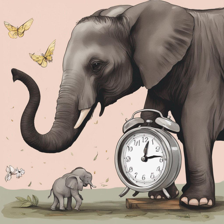

In [17]:
Image.fromarray(frame_ori.cpu().detach().numpy()).resize((224,224))

In [18]:
Audio(file['audio'],rate=16000)

In [19]:
Audio(file2['audio'],rate=16000)

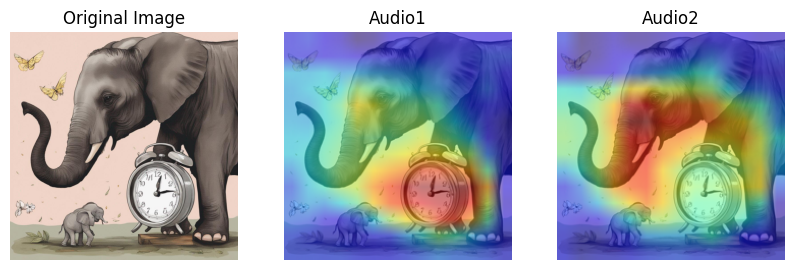

In [20]:
plt.figure(figsize=(10,30))
for i in range(len(overlaid_images)):
    plt.subplot(1,3,i+1)
    plt.imshow(overlaid_images[i])
    plt.title(names[i])
    plt.axis('off')

## Section 5 - Try another method from our group
* Load the ACLSSL model
* Initialize the Dataset Loader for the model
* Draw the Audio-Visual heatmap and the overlay on the original Image
* Try your own image and audio

# Can CLIP Help Sound Source Localization? (WACV 2024)
### Sooyoung Park*, Arda Senocak*, Joon Son Chung

In [21]:
import os
from ACLSSL.modules.models import *
from ACLSSL.modules.arg_utils import int_or_int_list_or_none
from ACLSSL.util import get_prompt_template
from PIL import Image
import torchaudio
from torchvision import transforms as vt
import matplotlib.pyplot as plt
import cv2
import numpy as np

### Model Load

In [22]:
device = torch.device('cpu')

save_path = './ACLSSL/checkpoints'  # Directory to save model checkpoints
model_name = 'ACL_ViT16'  # Name of the model to be used
exp_name = '0'  # Experiment identifier for model versioning

model_exp_name = f'{model_name}_{exp_name}' if exp_name != "" else model_name
model_conf_file = f'./ACLSSL/config/model/{model_name}_demo.yaml'

ACL_model = ACL(model_conf_file, device)
ACL_model.train(False)

postfix = 'best'
model_dir = os.path.join(save_path, model_exp_name, f'Param_{postfix}.pth')
ACL_model.load(model_dir)

prompt_template, text_pos_at_prompt, prompt_length = get_prompt_template()


## Initialize Data Loader

In [23]:
import torchaudio.transforms as T

def get_audio(wav_path):
    SAMPLE_RATE = 16000 
    set_length = 10 
    
    
    torchaudio.set_audio_backend("soundfile")

    
    audio_file, obs_sr = torchaudio.load(wav_path)

    # If the audio has more than one channel, take the first channel
    if audio_file.shape[0] != 1:
        audio_file = audio_file[:1]

    # Resample the audio to the target sample rate if necessary
    if obs_sr != SAMPLE_RATE:
        resampler = T.Resample(obs_sr, SAMPLE_RATE, dtype=audio_file.dtype)
        audio_file = resampler(audio_file)

    # Remove the channel dimension as we are working with mono audio
    audio_file = audio_file.squeeze(0)

    # Trim or pad the audio to the set length (10 seconds)
    if audio_file.shape[0] > (SAMPLE_RATE * set_length):
        # Trim to 10 seconds if longer
        audio_file = audio_file[:SAMPLE_RATE * set_length]

    if audio_file.shape[0] < (SAMPLE_RATE * set_length):
        # Pad with zeros if shorter
        pad_len = (SAMPLE_RATE * set_length) - audio_file.shape[0]
        pad_val = torch.zeros(pad_len)
        audio_file = torch.cat((audio_file, pad_val), dim=0)

    return audio_file

def get_image(img_path):
    image_file = Image.open(img_path)
    return image_file

input_resolution = 224

image_transform = vt.Compose([
    vt.Resize((input_resolution, input_resolution), vt.InterpolationMode.BICUBIC),  # Resize to 224x224 using bicubic interpolation
    vt.ToTensor(),  # Convert the image to a tensor
    vt.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),  # Normalize using the CLIP model's mean and std
])


### Draw the overlay

In [24]:
def draw_overlaid(original_image: Image.Image, heatmap_image: Image.Image) -> Image.Image:
    '''
    Create an overlaid image by combining an original image with a heatmap.

    Args:
        original_image (Image.Image): The original image on which the heatmap will be overlaid.
        heatmap_image (Image.Image): The heatmap to overlay on the original image.

    Returns:
        Image.Image: The combined image with the heatmap overlay.
    '''
    heatmap_image = cv2.applyColorMap(np.array(heatmap_image), cv2.COLORMAP_JET)
    overlaid_image = cv2.addWeighted(np.array(original_image), 0.5, heatmap_image, 0.5, 0)
    overlaid_image = Image.fromarray(overlaid_image)
    
    return overlaid_image


In [25]:
query = 1333

### Get the data samples for Sound Localization

In [26]:
file = loader.getitem(query*2)[2]
file2 = loader.getitem(query*2+1)[2]
audio1_path = file['audio']
audio2_path = file2['audio']
image_path = file['image']

### Learn Sound Localization Model

In [27]:
audios = []

audio = get_audio(audio1_path)
audio = audio.unsqueeze(0)
audios.append(audio)

audio = get_audio(audio2_path)
audio = audio.unsqueeze(0)
audios.append(audio)

audios = torch.vstack(audios)

images = get_image(image_path)
images = image_transform(images)
images = images.unsqueeze(0) 

# Retrieve placeholder tokens from the model
placeholder_tokens = ACL_model.get_placeholder_token(prompt_template.replace('{}', ''))
placeholder_tokens = placeholder_tokens.repeat((audios.shape[0], 1))  # Repeat tokens for each audio sample

# Encode the audio to produce audio-driven embeddings
audio_driven_embedding = ACL_model.encode_audio(
    audios.to(ACL_model.device),
    placeholder_tokens,  # Placeholder tokens
    text_pos_at_prompt,  # Position of text in the prompt
    prompt_length  # Length of the prompt
)

out_dict = ACL_model(images.to(ACL_model.device), audio_driven_embedding, 224)

overlaid_images = []

original_image = Image.open(image_path).resize((224, 224))
overlaid_images.append(original_image)

for i in range(audios.shape[0]):
    img_uint8 = out_dict['heatmap'][i][0].cpu().detach()
    img_uint8 = 255 - img_uint8 * 255

    img_uint8 = img_uint8.type(torch.uint8).numpy()
    heatmap_image = Image.fromarray(img_uint8)

    overlaid_image = draw_overlaid(original_image, heatmap_image)
    overlaid_images.append(overlaid_image)

names = ['Original Image', 'Audio1', 'Audio2']


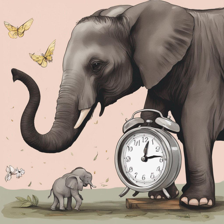

In [28]:
Image.open(image_path).resize((224,224))

In [29]:
Audio(audio1_path,rate=16000)

In [30]:
Audio(audio2_path,rate=16000)

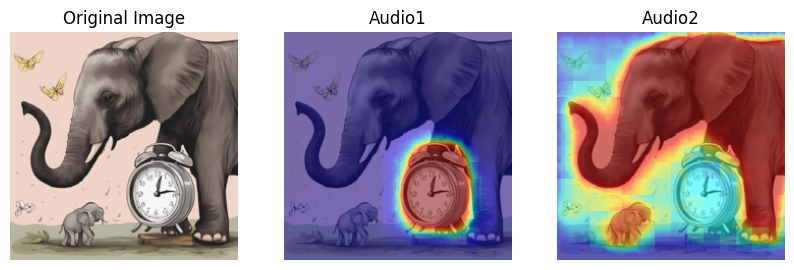

In [31]:
plt.figure(figsize=(10,30))
for i in range(len(overlaid_images)):
    plt.subplot(1,3,i+1)
    plt.imshow(overlaid_images[i])
    plt.title(names[i])
    plt.axis('off')

## Try your own Image and Audio

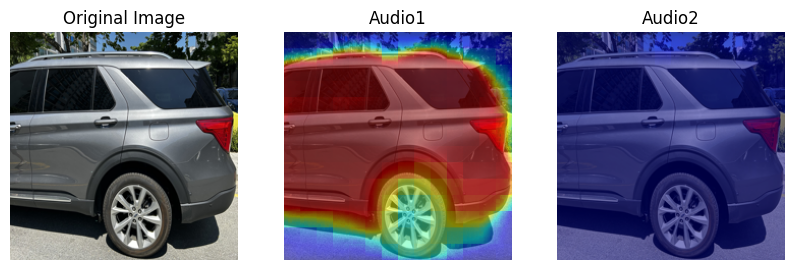

In [32]:
audios =[]
audio = get_audio('car_engine.mp3')
audio = audio.unsqueeze(0)
audios.append(audio)
audio = get_audio('./ACLSSL/accordion_baby_10467_baby.wav')
audio = audio.unsqueeze(0)
audios.append(audio)
audios = torch.vstack(audios)
images = get_image('car_img.jpeg')
images = image_transform(images)
images = images.unsqueeze(0)

placeholder_tokens = ACL_model.get_placeholder_token(prompt_template.replace('{}', ''))
placeholder_tokens = placeholder_tokens.repeat((audios.shape[0], 1))
audio_driven_embedding = ACL_model.encode_audio(audios.to(ACL_model.device), placeholder_tokens, text_pos_at_prompt,
                                            prompt_length)
out_dict = ACL_model(images.to(ACL_model.device), audio_driven_embedding, 224)

overlaid_images = []
original_image = Image.open('car_img.jpeg').resize((224, 224))
overlaid_images.append(original_image)

for i in range(audios.shape[0]):
    img_uint8 = out_dict['heatmap'][i][0].cpu().detach()
    img_uint8 = 255-img_uint8*255
    img_uint8 = img_uint8.type(torch.uint8).numpy()
    heatmap_image = Image.fromarray(img_uint8)

    overlaid_image = draw_overlaid(original_image, heatmap_image)
    overlaid_images.append(overlaid_image)
names = ['Original Image','Audio1','Audio2']

plt.figure(figsize=(10,30))
for i in range(len(overlaid_images)):
    plt.subplot(1,3,i+1)
    plt.imshow(overlaid_images[i])
    plt.title(names[i])
    plt.axis('off')